# 535WayGO

#### You are now an owner of a successful Autonomous Trucking company called 535WayGO. Congrats! 

At a busy weekend you have to assign your drivers loading tasks from 10 different locations. 

You need to find the optimal number of drivers and routes that they should take to complete the task. Each truck can carry upto 15 boxes. Each location (node) has between 1-10 boxes to be loaded. 

## How do we solve this problem? 

Well first we need to figure out how many vehicles we will need to load all our boxes. We formulate this as a bin packing problem. Finally, we solve the multiple vehicle routing problem as a variant of a multi-agent variant of the travelling salesmen problem with capacity constraints. Known as Capacitated vehcile roting problem (CVRP). 

In [1]:
import time
from itertools import cycle

import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import pyomo.environ as pyo
from pyomo.contrib.appsi.solvers.highs import Highs
from pyomo.contrib.appsi.solvers.gurobi import Gurobi


## Initialize your parameters

In [2]:
np.random.seed(42)

### Number of nodes (locations)
N = 10
### Total Number of boxes at each location 
demands = np.random.randint(1, 10, size=N)
### No boxes at the starting point 
demands[0] = 0

### Total number of boxes each truck can take 
capacity = 15

### Random 2D coordinates for node locations 
coordinates = np.random.rand(N, 2)

### Get the distance between each node in matrix form 
distances = squareform(pdist(coordinates, metric="euclidean"))
distances = np.round(distances, decimals=4)

In [3]:
    
 
# Feasible limits
min_vehicles = np.ceil(sum(demands) / capacity)
# Design choice 
max_vehicles = 2 * int(min_vehicles)
    



In [4]:
n_vehicles = 4

## CVRP

For a routing problem we want to minimize the total cost of traversal 

$$
\begin{align*}
\text{min} \quad & \sum_{k \in K}\sum_{i \in V}\sum_{j \in V} c_{i, j} x_{i, j, k} \\ 
\text{where:} \\
c_{i, j} \quad & \text{is the cost of traversal from node i to j} \\
x_{i, j, k} \quad & \text{is the binary variable that indicates an active arc from node i to node j performed by vehicle k} \\
K \quad & \text{Is the set of all vehicles, found from the solution of our bin packing problem} \\
V \quad & \text{Is the set of all nodes}
\end{align*}

In [5]:
model = pyo.ConcreteModel()

## Sets
$$
\begin{align*}
& K \quad  \text{Is the set of all vehicles, found from the solution of our bin packing problem} \\
& V \quad  \text{Is the set of all nodes} \\
& A \quad  \text{Is the set of all possible arcs between nodes}
\end{align*}
$$


In [6]:
model.V = pyo.Set(initialize=range(len(demands)))
model.A = pyo.Set(initialize=[(i, j) for i in model.V for j in model.V if i != j])
model.K = pyo.Set(initialize=range(n_vehicles))

## Parameters
$$
\begin{align*}
& Q \quad  \text{Is the vehicle capacity} \\
& c_{i,j} \quad  \text{Is the distance (cost of traversal) between any two nodes i, j} \\
& q_{k} \quad  \text{Is the demand of any node k}
\end{align*}
$$



In [7]:
model.Q = pyo.Param(initialize=capacity)
model.c = pyo.Param(model.A, initialize={(i, j): distances[i, j] for (i, j) in model.A})
model.q = pyo.Param(model.V, initialize={i: d for (i, d) in enumerate(demands)})

## Variables
$$
\begin{align*}
& x_{i, j, k} \quad \text{is the binary variable that indicates an active arc from node i to node j performed by vehicle k} & \\
& y_{i,k} \quad \text{is the binary variable that indicates that the demand from node i is fulfilled by vehicle k} &
\end{align*}
$$



In [8]:
model.x = pyo.Var(model.A, model.K, within=pyo.Binary)
model.y = pyo.Var(model.V, model.K, within=pyo.Binary)

## Constraints

 
$$
\begin{align}
    \quad & \sum_{k \in K}\sum_{j \in V} x_{i, j, k} = \sum_{k \in K}\sum_{j \in V} x_{j, i, k} = 1 & \forall \; i \in V \setminus \{0\} \\
    & \sum_{j \in V} x_{i, j, k} = \sum_{j \in V} x_{j, i, k} = y_{i, k} & \forall \; i \in V \setminus \{0\} \; k \in K \\
    & \sum_{i \in V} q_{i} y_{i, k} \leq Q & \forall \; k \in K \\
    & \sum_{k \in K}\sum_{j \in V} x_{0, j, k} = \sum_{k \in K}\sum_{i \in V} x_{i, 0, k} = K \\
    & \sum_{i \in S}\sum_{j \notin S} x_{i, j, k} \geq y_{h, k} & \forall \; S \subseteq V \setminus \{0\} \; h \in S \; k \in K
\end{align}
$$

Eq. 1 constraints: Visit each node atleast once, so each node has one arc arrive and leave from it except for the depot. 

Eq. 2 constraints: If any arc variable indexed by vehicle k goes into one node i or out of it, the demand q of this node is assigned to vehicle k.

Eq. 3 constraints: The total demand assigned to a vehicle must not exceed its capacity Q.

Eq. 4 constraints: Exactly |K| nodes start at the depot and arrive at the depot.

Eq. 5 constraints: There are no subtours. (We will at subtour elimination later in the notebook)

In [9]:
### From eq 1, 4
def arcs_in(model, i):
    if i == model.V.first():
        return sum(model.x[:, i, :]) == len(model.K)
    else:
        return sum(model.x[:, i, :]) == 1.0

### From eq 1, 4
def arcs_out(model, i):
    if i == model.V.first():
        return sum(model.x[i, :, :]) == len(model.K)
    else:
        return sum(model.x[i, :, :]) == 1.0

### From eq 2
def vehicle_assignment(model, i, k):
    return sum(model.x[:, i, k]) == model.y[i, k]

### From eq 2
def comp_vehicle_assignment(model, i, k):
    return sum(model.x[i, :, k]) == model.y[i, k]

### From eq 3
def capacity_constraint(model, k):
    return sum(model.y[i, k] * model.q[i] for i in model.V) <= model.Q

### From eq 5
def subtour_elimination(model, S, Sout, h, k):
    nodes_out = sum(model.x[i, j, k] for i in S for j in Sout)
    return model.y[h, k] <= nodes_out

### Pyomo signature: function(model, *domain)
model.arcs_in = pyo.Constraint(model.V, rule=arcs_in)
model.arcs_out = pyo.Constraint(model.V, rule=arcs_out)
model.vehicle_assignment = pyo.Constraint(model.V, model.K, rule=vehicle_assignment)
model.comp_vehicle_assignment = pyo.Constraint(model.V, model.K, rule=comp_vehicle_assignment)
model.capacity_constraint = pyo.Constraint(model.K, rule=capacity_constraint)
model.subtour_elimination = pyo.ConstraintList()

## Objective

In [10]:
#  Minimizing cost (distance) of traversal. 
model.obj = pyo.Objective(
    expr=
        sum(
        model.x[i, j, k] * model.c[i, j]
        for (i, j) in model.A
        for k in model.K
    ),
    sense=pyo.minimize,
)

### Solve (no subtour elimination)

In [11]:
# Use a Gurobi solver
solver = Gurobi()
solver.gurobi_options = {
    "log_file": "Gurobi.log",
    "mip_heuristic_effort": 0.2,
    "mip_detect_symmetry": True,
    "mip_rel_gap": 1e-6,
}
solution = solver.solve(model)
sol = solver.solve(model)

In [30]:
# Returns all the active arcs in the solved tour
def find_arcs(model):
    arcs = []
    for i, j in model.A:
        for k in model.K:
            if np.isclose(model.x[i, j, k].value, 1, atol=1e-1):
                arcs.append((i, j))
    return arcs

# Finding a set of strongly connected graph. if the graph does not conatin the depot it is a subtour. 
arcs= find_arcs(model)
G = nx.DiGraph(arcs)
subtours = list(nx.strongly_connected_components(G))

# Finds the current solution (without subtour elimination). 
def find_tours(model):
    tours = []
    for k in model.K:
        node = 0
        tours.append([0])
        while True:
            for j in model.V:
                if (node, j) in model.A:
                    if np.isclose(model.x[node, j, k].value, 1):
                        node = j
                        tours[-1].append(node)
                        break
            if node == 0:
                break
    for sub in range(len(subtours)):
        if (0 not in subtours[sub]):
            tours.append(list(subtours[sub]))
    return tours


In [31]:
tours = find_tours(model)
print(tours)

[[0, 4, 2, 0], [0, 8, 5, 6, 0], [0, 3, 7, 0], [0, 9, 1, 0]]


In [32]:
for k in model.K:
    print("Vehicle %d goes to nodes ", k)
    for i in model.V:
        if (model.y[i,k].value == 1.0):
            print(i)            

Vehicle %d goes to nodes  0
0
2
4
Vehicle %d goes to nodes  1
0
5
6
8
Vehicle %d goes to nodes  2
0
3
7
Vehicle %d goes to nodes  3
0
1
9


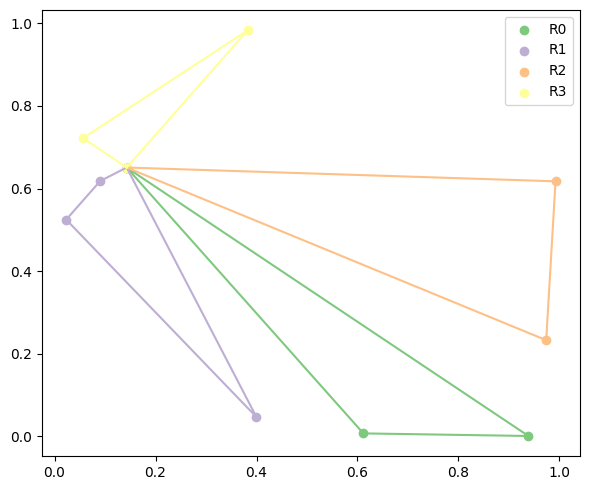

In [33]:
# Visualize the solution
# Choosing colors
cmap = plt.get_cmap("Accent")
# cmap = mpl.colormaps["tab20"]
colors = cycle(cmap.colors)
# Now the figure
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
for r, tour in enumerate(tours):
    c = next(colors)
    t = np.array(tour)
    x = coordinates[t, 0]
    y = coordinates[t, 1]
    ax.scatter(x, y, color=c, label=f"R{r}")
    ax.plot(x, y, color=c)

ax.legend()
fig.tight_layout()
plt.show()

Why is this a valid solution. Can we find a constraint that it valides? Unfortunately no. We need to subtour elimination constraints.

Given in Eq. 5 of our constraints, we say that if a vehicle is picking up the boxes at location i (in a subtour), i.e., $y_{i,k} = 1$ , then the sum of nodes leaving this subtour should be greater than or equal to 1. 
From the current plot we can see that the cuurent subtour with nodes 3,9 violates the contsraint. So adding this constraint will force the solver to find another solution. 

So we recursively eliminate subtours for this problem. 

In [16]:
# Returns all the possible arcs 
def find_arcs(model):
    arcs = []
    for i, j in model.A:
        for k in model.K:
            if np.isclose(model.x[i, j, k].value, 1, atol=1e-1):
                arcs.append((i, j))
    return arcs

# Returns all the subtours, strongly connected graphs
def find_subtours(arcs):
    G = nx.DiGraph(arcs)
    subtours = list(nx.strongly_connected_components(G))
    return subtours

# All subtours (1 in final solution) must contain the depot 
def eliminate_subtours(model, subtours):
    proceed = False
    for S in subtours:
        if 0 not in S:
            proceed = True
            Sout = {i for i in model.V if i not in S}
            for h in S:
                for k in model.K:
                    model.subtour_elimination.add(subtour_elimination(model, S, Sout, h, k))
    return proceed

# Recursively add subtour eliminitaion contraints
def _solve_step(model, solver, verbose=True):
    sol = solver.solve(model)
    arcs = find_arcs(model)
    subtours = find_subtours(arcs)
    if verbose:
        print(f"Current subtours: {subtours}")
    time.sleep(0.1)
    proceed = eliminate_subtours(model, subtours)
    return sol, proceed 


def solve(model, solver, verbose=True):
    proceed = True
    while proceed:
        sol, proceed = _solve_step(model, solver, verbose=verbose)
    return sol

In [29]:
# Visualize one step at a time 
## sol, proceed = _solve_step(model, solver, verbose=True)

Current subtours: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]


In [18]:
sol = solve(model, solver)

Current subtours: [{0, 1, 2, 4, 5, 6, 7, 8}, {9, 3}]
Current subtours: [{0, 1, 2, 5, 6, 7, 8, 9}, {3, 4}]
Current subtours: [{0, 1, 2, 3, 4, 7, 8, 9}, {5, 6}]
Current subtours: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]


## Solution

In [19]:
def find_tours(model):
    tours = []
    for k in model.K:
        node = 0
        tours.append([0])
        while True:
            for j in model.V:
                if (node, j) in model.A:
                    if np.isclose(model.x[node, j, k].value, 1):
                        node = j
                        tours[-1].append(node)
                        break
            if node == 0:
                break
    return tours

In [20]:
tours = find_tours(model)
print(tours)

[[0, 4, 2, 0], [0, 8, 5, 6, 0], [0, 3, 7, 0], [0, 9, 1, 0]]


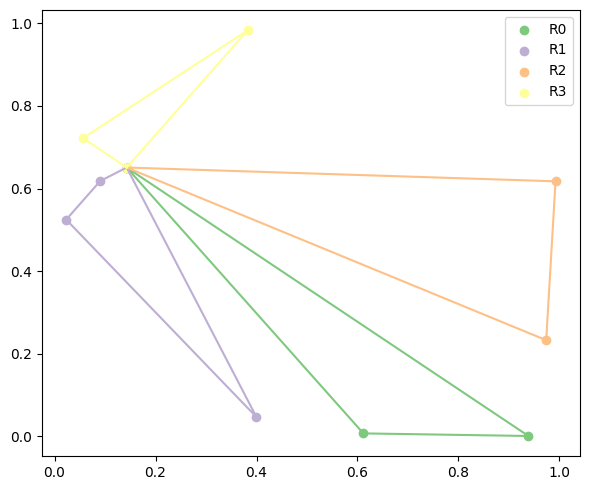

In [21]:
# Visualize the solution
# Choosing colors
cmap = plt.get_cmap("Accent")
# cmap = mpl.colormaps["tab20"]
colors = cycle(cmap.colors)
# Now the figure
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
for r, tour in enumerate(tours):
    c = next(colors)
    t = np.array(tour)
    x = coordinates[t, 0]
    y = coordinates[t, 1]
    ax.scatter(x, y, color=c, label=f"R{r}")
    ax.plot(x, y, color=c)

ax.legend()
fig.tight_layout()
plt.show()

### Limitations 

The implementation given for our toy problem seems easy enough. However, is it scaleable? 

Unfortunately no. 
DFJ’s approach introduces subtour constraints for all possible sets of locations i.e 2^n for n locations. The combinatorial complexity of our formulation is NP hard. 
Thus, for a real world problem this formulation will not scale and we need some heuristic solvers. There is a wide variety of literature in this area. A lot of these heuristic are also task specific, and is relevant area of research. 

Google OR Tools provides a neat wrapper to solve these large scale routing problems, which we will use next to solve for 150 locations with 14 vehicles

# Scaling Up 
### 535WayGo got picked up for Series C funding. And now you have to plan for a much bigger fleet. 

You now have 150 pickup locations and 14 vehicles. You will need to turn to a heuristic solver for the scale of the new problem.

# Heuristics - CVRP


In [22]:
from itertools import cycle

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib as mpl
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## Instantiate data

In [23]:
dataset = pd.read_csv("./tai150d.csv", index_col=0)
coordinates = dataset.loc[:, ["x", "y"]]
demands = dataset.d.values

In [24]:
capacity = 1874
n_vehicles = 14
N = coordinates.shape[0]

In [25]:
distances = squareform(pdist(coordinates, metric="euclidean"))
distances = np.round(distances, decimals=4)

## Model

We use a Google OR Tools routing wrapper for this task. The syntax may look very different but the only difference really is the subtour elimination which is now done using different heuristics. 

In [26]:
# Create the routing index manager: number of nodes, number of vehicles, depot node
manager = pywrapcp.RoutingIndexManager(
    N, n_vehicles, 0
)

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

### Parameters

In [27]:
# Defines the distance etween any two nodes (c_{i,j})
# Same valid for any callback related to arcs/edges

def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distances[from_node, to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

In [28]:
# Returns the demand of any node (q{i})
# Same valid for any callback related to nodes

def demand_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return demands[from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

### Constraints

In [29]:
# Adding our capacity constraints (assuming homogeneous fleet)
# Any constraint associated with vehicles can take same arguments
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    [capacity,] * n_vehicles,  # vehicle maximum capacities (list for each vehicle)
    True,  # start cumul to zero
    'Capacity'
)

True

### Objective

In [30]:
# Setting the minimum distance objective for solution
# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Solution

In [31]:
# Setting heuristic strategies
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.CHRISTOFIDES
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(300)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [32]:
# Total distance covered by all the vehicles 
solution.ObjectiveValue()

2703

In [33]:
tours = []
for vehicle_id in range(n_vehicles):
    index = routing.Start(vehicle_id)
    tours.append([])
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        tours[-1].append(node_index)
    else:
        node_index = manager.IndexToNode(index)
        tours[-1].append(node_index)

print(tours)

[[0, 22, 27, 14, 23, 111, 115, 109, 110, 121, 113, 118, 26, 13, 0], [0, 138, 107, 104, 108, 106, 105, 100, 101, 102, 103, 74, 0], [0, 79, 135, 134, 137, 136, 68, 70, 0], [0, 142, 96, 31, 32, 30, 29, 99, 97, 145, 146, 75, 0], [0, 57, 65, 56, 63, 45, 38, 44, 39, 40, 33, 37, 42, 43, 35, 34, 46, 49, 41, 64, 5, 11, 0], [0, 2, 3, 62, 52, 85, 131, 126, 122, 47, 0], [0, 7, 51, 4, 60, 139, 141, 0], [0, 10, 20, 12, 28, 17, 21, 16, 15, 24, 0], [0, 150, 98, 94, 95, 0], [0, 59, 48, 50, 36, 61, 58, 53, 55, 1, 0], [0, 54, 83, 129, 127, 132, 133, 130, 128, 124, 123, 125, 84, 86, 82, 0], [0, 78, 76, 73, 81, 72, 77, 80, 143, 148, 0], [0, 6, 8, 9, 18, 25, 19, 116, 114, 119, 117, 112, 120, 89, 87, 90, 92, 93, 91, 88, 69, 71, 67, 66, 0], [0, 140, 144, 147, 149, 0]]


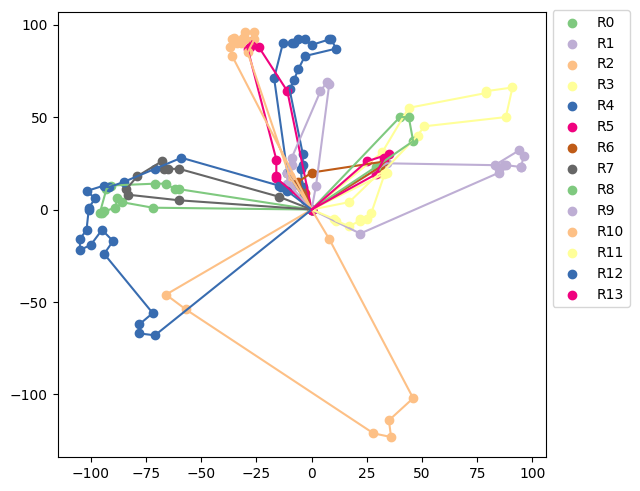

In [34]:
# Choosing colors
cmap = plt.get_cmap("Accent")
# cmap = mpl.colormaps["tab20"]
colors = cycle(cmap.colors)

# Now the figure
fig, ax = plt.subplots(figsize=[6.5, 5], dpi=100)
for r, tour in enumerate(tours):
    c = next(colors)
    t = np.array(tour)
    x = coordinates.values[t, 0]
    y = coordinates.values[t, 1]
    ax.scatter(x, y, color=c, label=f"R{r}")
    ax.plot(x, y, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
fig.tight_layout()
plt.show()

### References

The content in this notebook follow this article online: https://towardsdatascience.com/the-vehicle-routing-problem-exact-and-heuristic-solutions-c411c0f4d734